# HW3 - E-Commerce

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests


In [ ]:
file_path = '/content/drive/MyDrive/DSCI599/Datasets/UCI Dataset/UCI E - Commerce.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


## RFM Analysis

In [ ]:
from datetime import datetime, timedelta

# Convert InvoiceDate column to datetime type
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate the total amount for each order
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

# Determine the cut-off date for the analysis (last invoice date plus one day to ensure the calculated Recency is correct)
analysis_end_date = data['InvoiceDate'].max() + timedelta(days=1)

# Calculate RFM metrics for each customer
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_end_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'TotalAmount': 'Monetary'})

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Customer Subdivision

In [ ]:
# Calculate quartiles
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

# Calculate RFM score
# Define a function to assign scores to Recency and Frequency/Monetary based on quartiles
def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

rfm['R_Score'] = rfm['Recency'].apply(r_score, args=('Recency', quantiles))
rfm['F_Score'] = rfm['Frequency'].apply(fm_score, args=('Frequency', quantiles))
rfm['M_Score'] = rfm['Monetary'].apply(fm_score, args=('Monetary', quantiles))

# Create a new column RFM_Segment that combines R, F, and M scores into one value
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,2,1,121,4
12347.0,2,7,4310.00,4,4,4,444,12
12348.0,75,4,1797.24,2,3,4,234,9
12349.0,19,1,1757.55,3,1,4,314,8
12350.0,310,1,334.40,1,1,2,112,4


<ipython-input-7-ac876911c880>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RFM_Score', data=rfm, palette='coolwarm')


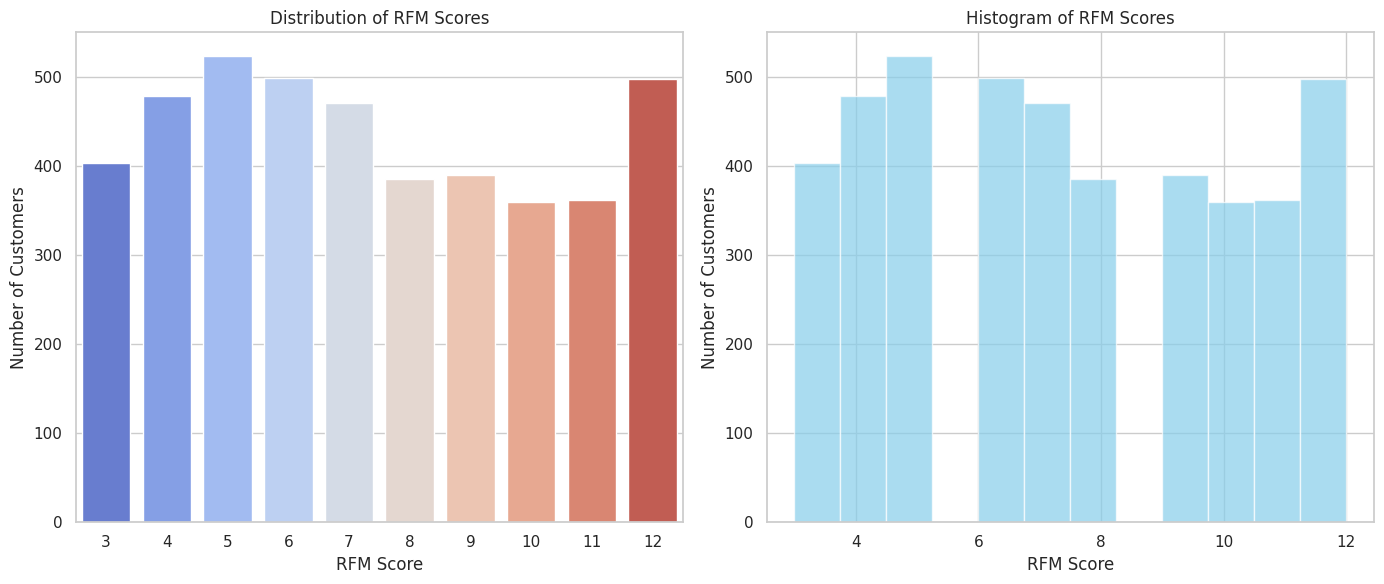

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='RFM_Score', data=rfm, palette='coolwarm')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')

plt.subplot(1, 2, 2)
rfm['RFM_Score'].plot(kind='hist', bins=12, alpha=0.7, color='skyblue')
plt.title('Histogram of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()


### Distribution of RFM Scores
- This bar chart shows the distribution of customers across different RFM scores. Most customers have scores in the middle range (4-7), suggesting that there's a broad middle segment of customers with moderate recency, frequency, and monetary values.
- Fewer customers have the highest RFM score of 12, which indicates a smaller segment of highly valuable customers who shop frequently, spend more, and have shopped recently.

### Histogram of RFM Scores
- The histogram reveals a distribution with a relatively even spread of RFM scores among customers. However, there are noticeable dips for scores 8 and 10, which may indicate specific segments where customer engagement could be improved.


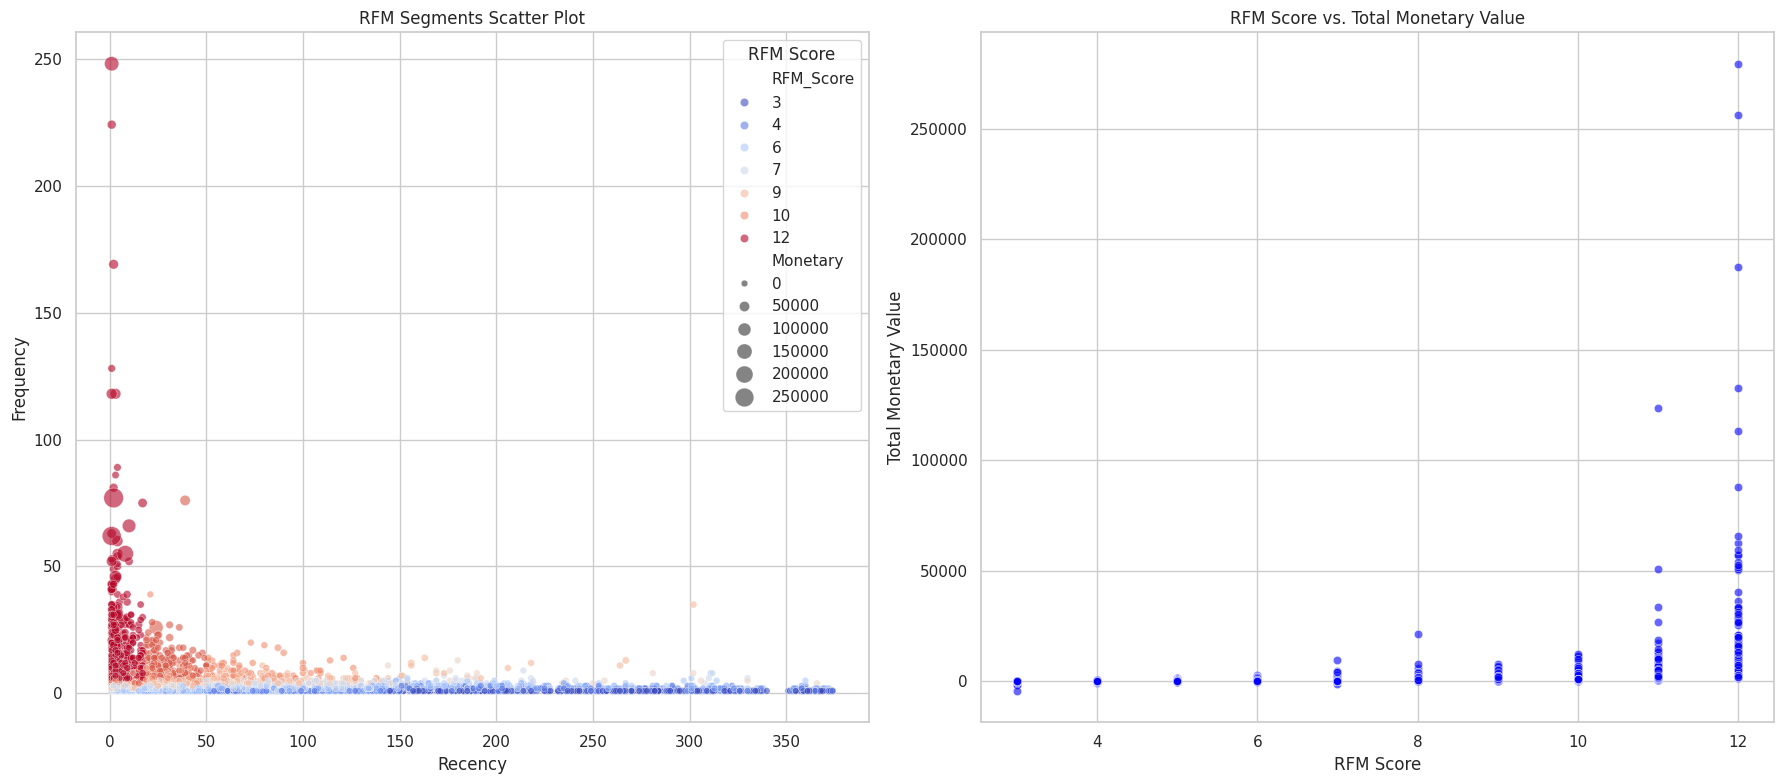

In [ ]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Recency', y='Frequency', hue='RFM_Score', data=rfm, palette='coolwarm', size='Monetary', sizes=(20, 200), alpha=0.6)
plt.title('RFM Segments Scatter Plot')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='RFM Score')

plt.subplot(1, 2, 2)
sns.scatterplot(x='RFM_Score', y='Monetary', data=rfm, color='blue', alpha=0.6)
plt.title('RFM Score vs. Total Monetary Value')
plt.xlabel('RFM Score')
plt.ylabel('Total Monetary Value')

plt.tight_layout()
plt.show()


### RFM Segments Scatter Plot
- This scatter plot visualizes customers across two dimensions: Recency and Frequency, with the hue indicating the RFM score and the size of the dot indicating the Monetary value.
- Customers with a lower recency and higher frequency tend to have higher RFM scores, suggesting that they are more engaged and valuable to the business.
- There's a concentration of customers with high frequency but varying recency, suggesting that even among frequent shoppers, there's a range in how recently they've made their purchases.

### RFM Score vs. Total Monetary Value
- This scatter plot shows the relationship between RFM scores and the total monetary value of purchases. There's a trend where higher RFM scores correlate with higher monetary values, although there are outliers.
- Customers with the highest RFM scores (12) also have some of the highest total monetary values, indicating that they are likely to be the most valuable customers in terms of revenue.

## Analysis of best-selling and slow-selling products

In [ ]:
# Best-selling product analysis
# We will identify best-selling items by calculating the total sales of each item
top_selling_products = data.groupby('Description').agg(TotalRevenue=('TotalAmount', 'sum'),
                                                       TotalUnits=('Quantity', 'sum')).reset_index()
top_selling_products = top_selling_products.sort_values(by='TotalRevenue', ascending=False)

top_10_selling_products = top_selling_products.head(10)

# Analysis of slow-moving goods
# We will identify slow-moving items by finding items with lower total sales
# Here we assume that slow-moving products are products with lower sales volume and lower sales
slow_selling_products = top_selling_products.sort_values(by='TotalRevenue', ascending=True)

slow_10_selling_products = slow_selling_products.head(10)

(top_10_selling_products, slow_10_selling_products)


(                             Description  TotalRevenue  TotalUnits
 1098                      DOTCOM POSTAGE     206245.48         707
 2915            REGENCY CAKESTAND 3 TIER     164762.19       13033
 3918  WHITE HANGING HEART T-LIGHT HOLDER      99668.47       35317
 2471                       PARTY BUNTING      98302.98       18022
 1866             JUMBO BAG RED RETROSPOT      92356.03       47363
 2803                  RABBIT NIGHT LIGHT      66756.59       30680
 2753                             POSTAGE      66230.64        3003
 2439     PAPER CHAIN KIT 50'S CHRISTMAS       63791.94       18902
 244        ASSORTED COLOUR BIRD ORNAMENT      58959.73       36381
 773                        CHILLI LIGHTS      53768.06       10229,
                          Description  TotalRevenue  TotalUnits
 171                       AMAZON FEE   -221520.500         -30
 2246                          Manual    -68671.640        3165
 281                  Adjust bad debt    -11062.060        

### Best-selling items (ranked by total sales revenue):
1. **DOTCOM POSTAGE**: This appears to be a charge related to online order postage fees rather than actual goods. The high revenue from this charge indicates the scale of online sales activity.
2. **REGENCY CAKESTAND 3 TIER**: This is a highly popular item with both high sales volume and revenue.
3. **WHITE HANGING HEART T-LIGHT HOLDER**: Similarly, this is a best-selling item with very high unit sales, indicating strong market demand.
4. **PARTY BUNTING**: Party decorations also show good sales performance.
5. **JUMBO BAG RED RETROSPOT**: Sales of these large capacity bags are the highest among all items, indicating their practicality and popularity.
6. **RABBIT NIGHT LIGHT**: Night light products perform well, indicating they may be attractive children's or home products.
7. **POSTAGE**: Similar to DOTCOM POSTAGE, this is the total revenue from related postage fees, indicating the importance of shipping items.
8. **PAPER CHAIN KIT 50'S CHRISTMAS**: Christmas decoration sets are also among the best-selling items.
9. **ASSORTED COLOUR BIRD ORNAMENT**: Multi-colored bird decorations show good sales performance, possibly due to their variety.
10. **CHILLI LIGHTS**: This is another unique decorative light that also shows good sales revenue.

### Slow-moving/Problematic items (ranked by total sales revenue):
1. **AMAZON FEE**: This is a fee related to the Amazon platform, negative revenue indicates refunds or other charges.
2. **Manual**: This may represent manually processed orders or adjustments, with negative values indicating refunds or discounts.
3. **Adjust bad debt**: This is evidently a bad debt adjustment, negatively impacting total revenue.
4. **CRUK Commission**: Possibly negative revenue related to charity donations or commissions.
5. **Bank Charges**: Negative revenue generated from bank charges, not actual goods.
6. **Discount**: Discounts provided to customers, reflected as negative revenue.
7. **SAMPLES**: Giving out samples may result in negative revenue.
8. **WHITE CHERRY LIGHTS**: Although a specific item, negative revenue may indicate returns or damage.
9. **CREAM SWEETHEART MAGAZINE RACK**: Magazine racks show negative revenue, possibly due to returns or poor sales.
10. **WOODEN BOX ADVENT CALENDAR**: Another specific item, negative revenue indicates possible returns or sales challenges.



In [ ]:
slow_30_selling_products = slow_selling_products.head(30)
slow_30_selling_products

,Description,TotalRevenue,TotalUnits
171,AMAZON FEE,-221520.500,-30
2246,Manual,-68671.640,3165
281,Adjust bad debt,-11062.060,3
934,CRUK Commission,-7933.430,-16
615,Bank Charges,-7175.639,-13
1126,Discount,-5696.220,-1194
3059,SAMPLES,-3049.390,-59
3903,WHITE CHERRY LIGHTS,-54.000,-8
922,CREAM SWEETHEART MAGAZINE RACK,-46.850,-3
3977,WOODEN BOX ADVENT CALENDAR,-45.700,-6


### Best-selling items:

1. **Home Decoration and Lighting**: For example, WHITE HANGING HEART T-LIGHT HOLDER and CHILLI LIGHTS are often popular for their ability to add to the ambience of a home.
2. **Practical Storage Solutions**: Like the JUMBO BAG RED RETROSPOT, this shows that consumers tend to purchase storage options that are both practical and attractive.
3. **Seasonal and Holiday Items**: For example, PAPER CHAIN KIT 50'S CHRISTMAS, these items have a surge in sales during certain seasons or holidays.
4. **Kitchen and Baking Supplies**: Such as REGENCY CAKESTAND 3 TIER, which usually sells well due to its functionality and popularity as a gift.

### Slow-moving/Problematic items:
- **Negative revenue items** (such as AMAZON FEE, Manual, Adjust bad debt, etc.) often do not represent actual products but rather operational expenses or financial adjustments. Their negative revenue may indicate refunds, bad debts, commissions, or fees, rather than the performance of product sales.
- **Items with negative sales revenue due to returns or damage** (such as WHITE CHERRY LIGHTS, CREAM SWEETHEART MAGAZINE RACK, etc.) may indicate situations of returns or inventory loss. This could be due to product quality issues, customer dissatisfaction, or damage during transportation.
- **Items with low sales volume**
  - **Products with specific themes or styles**: Some products may not have widespread appeal because they are too specific in style or theme. For example, a specific style of decorations or seasonal decorations may only be available to a specific customer group or time period. Popular within.
  - **High-priced or luxury products**: High-priced products usually do not sell as well as low-priced or mid-priced products because they target a smaller group of consumers.
- **Projects with zero sales revenue** (such as on cargo order, printing smudges/thrown away, etc.) may represent records of non-sales activities, such as wastage, scrap, or internal adjustments. They may not reflect sales performance in the market but rather the impact of other operational activities.


## Time Analysis

In [ ]:
# Convert InvoiceDate to datetime format to facilitate analysis
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Analyze buying patterns throughout the day
data['Hour'] = data['InvoiceDate'].dt.hour
hourly_sales = data.groupby('Hour').agg(TotalOrders=('InvoiceNo', pd.Series.nunique),
                                        TotalQuantity=('Quantity', 'sum')).reset_index()

# Analyze buying patterns over the week
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
weekly_sales = data.groupby('DayOfWeek').agg(TotalOrders=('InvoiceNo', pd.Series.nunique),
                                              TotalQuantity=('Quantity', 'sum')).reset_index()

# Analyze buying patterns over a month
data['DayOfMonth'] = data['InvoiceDate'].dt.day
monthly_sales = data.groupby('DayOfMonth').agg(TotalOrders=('InvoiceNo', pd.Series.nunique),
                                                TotalQuantity=('Quantity', 'sum')).reset_index()

# Analyze buying behavior and preferences in different countries or regions
country_sales = data.groupby('Country').agg(TotalOrders=('InvoiceNo', pd.Series.nunique),
                                            TotalQuantity=('Quantity', 'sum'),
                                            TotalRevenue=('UnitPrice', 'sum')).reset_index()

<ipython-input-12-bd038475bd68>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour', y='TotalQuantity', data=hourly_sales, ax=ax[0, 0], palette="viridis")
<ipython-input-12-bd038475bd68>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfWeek', y='TotalQuantity', data=weekly_sales, ax=ax[0, 1], palette="viridis")
<ipython-input-12-bd038475bd68>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayOfMonth', y='TotalQuantity', data=monthly_sales, ax=ax[1, 0], palette="viridis")
<ipython-input-12-bd038475bd68>:26: FutureWarning:

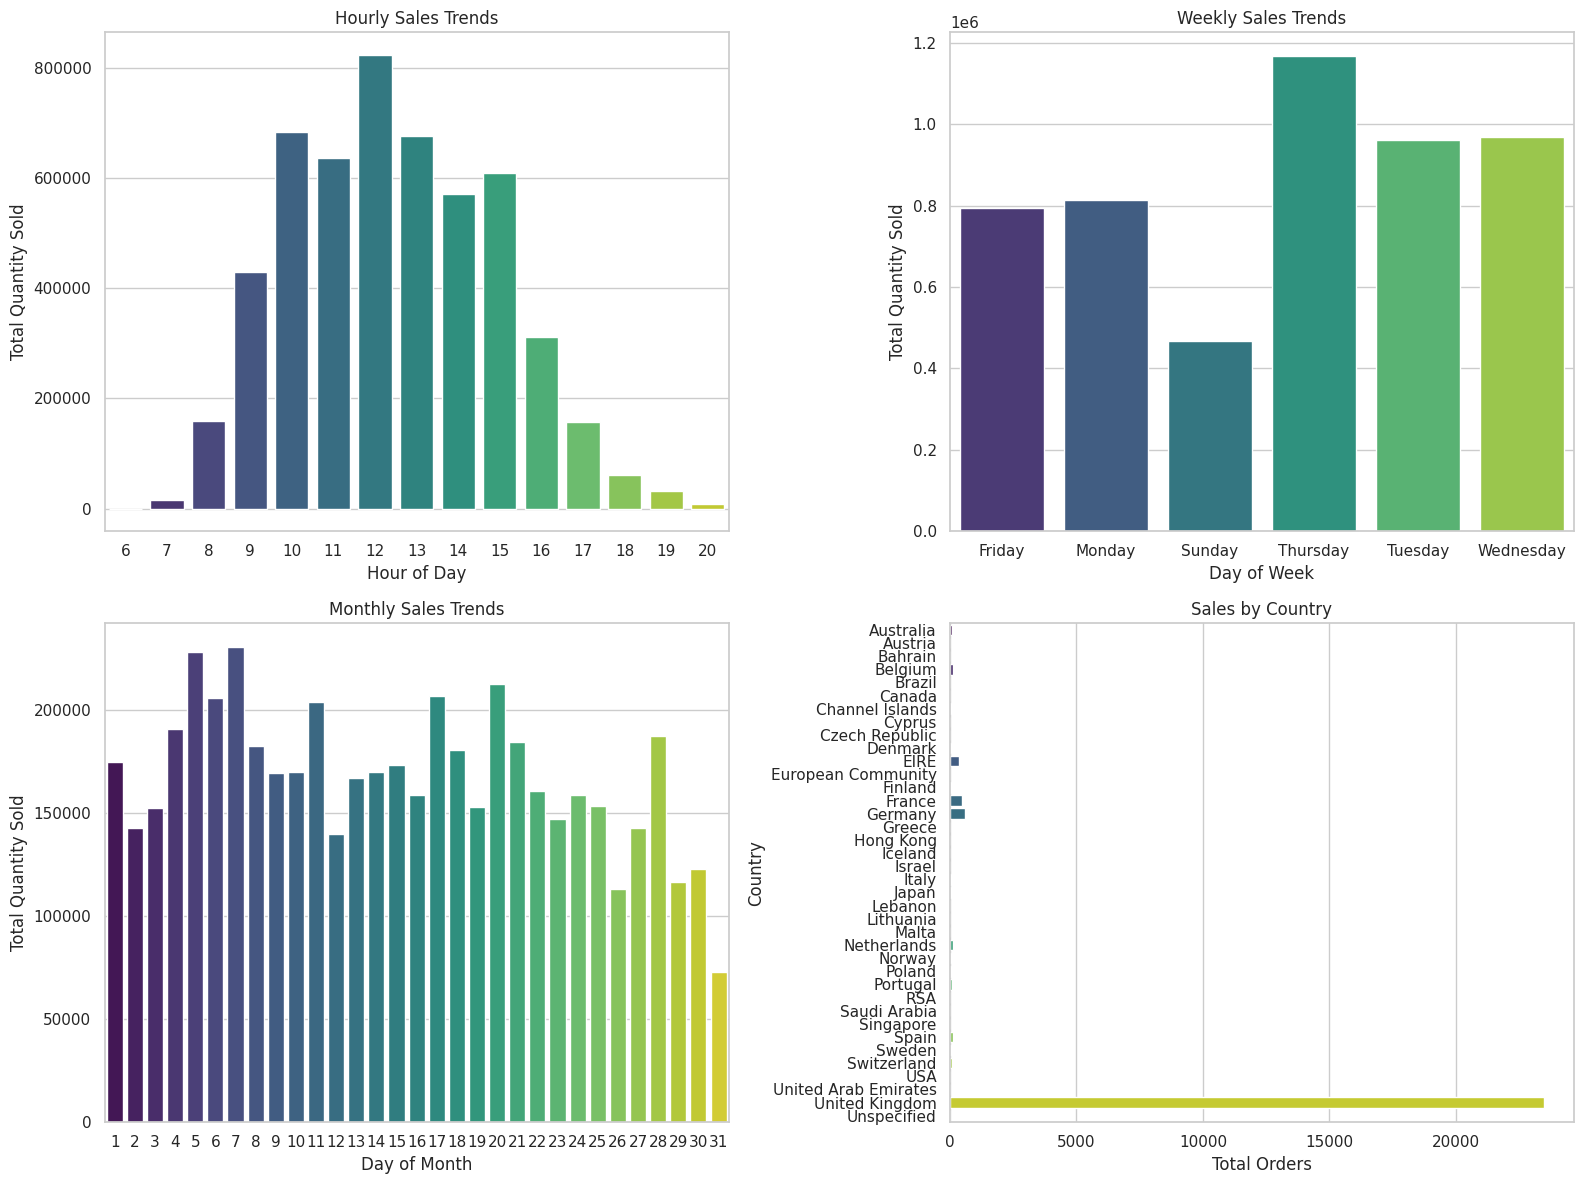

In [ ]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(x='Hour', y='TotalQuantity', data=hourly_sales, ax=ax[0, 0], palette="viridis")
ax[0, 0].set_title('Hourly Sales Trends')
ax[0, 0].set_xlabel('Hour of Day')
ax[0, 0].set_ylabel('Total Quantity Sold')

sns.barplot(x='DayOfWeek', y='TotalQuantity', data=weekly_sales, ax=ax[0, 1], palette="viridis")
ax[0, 1].set_title('Weekly Sales Trends')
ax[0, 1].set_xlabel('Day of Week')
ax[0, 1].set_ylabel('Total Quantity Sold')

sns.barplot(x='DayOfMonth', y='TotalQuantity', data=monthly_sales, ax=ax[1, 0], palette="viridis")
ax[1, 0].set_title('Monthly Sales Trends')
ax[1, 0].set_xlabel('Day of Month')
ax[1, 0].set_ylabel('Total Quantity Sold')

sns.barplot(x='TotalOrders', y='Country', data=country_sales, ax=ax[1, 1], palette="viridis")
ax[1, 1].set_title('Sales by Country')
ax[1, 1].set_xlabel('Total Orders')
ax[1, 1].set_ylabel('Country')

plt.tight_layout()
plt.show()


### Hourly Sales Trends
- The activity starts to pick up significantly from 7 AM and peaks between 10 AM to 12 PM, indicating a strong morning shopping trend.
- After midday, there's a noticeable decline in total quantity sold, with a smaller peak around 3 PM which then tapers off towards the evening.

### Weekly Sales Trends
- The total quantity sold is highest on Wednesday, followed by Tuesday and Monday, suggesting that the beginning of the week is a busy period for sales.
- There is a significant drop in sales on Sunday, indicating it may be the quietest day of the week, possibly due to store closures or reduced shopping hours.

### Monthly Sales Trends
- Sales appear to be strong at the beginning of the month, with the first day being particularly active.
- There is a general trend of declining sales towards the middle of the month with some fluctuation, followed by a slight increase towards the end of the month.

### Sales by Country
- The United Kingdom overwhelmingly dominates the market with the highest total number of orders by a large margin.
- Other countries, such as Germany, France, and EIRE (Ireland), also contribute to the sales, but to a much lesser extent compared to the UK.
- The distribution of sales across different countries suggests a concentrated market presence in the UK, with a significant but smaller international customer base.

## Association Rule Analysis

In [ ]:
!pip install mlxtend

In [ ]:
# Convert the product description corresponding to each invoice number in the data set into a list of transaction items
basket = data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

# Convert quantity to boolean
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

# Import apriori functions and association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Use apriori algorithm to get frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

# Calculate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)


In [ ]:
rules.head(25)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.042993,0.040088,0.026180,0.608944,15.190043,0.024457,2.454665,0.976134
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.040088,0.042993,0.026180,0.653061,15.190043,0.024457,2.758433,0.973181
2,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG PINK POLKADOT),0.042297,0.030394,0.021353,0.504836,16.609974,0.020068,1.958151,0.981302
3,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.030394,0.042297,0.021353,0.702557,16.609974,0.020068,3.219788,0.969254
4,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG SUKI DESIGN),0.042297,0.036080,0.020740,0.490329,13.590225,0.019214,1.891260,0.967333
5,(CHARLOTTE BAG SUKI DESIGN),(RED RETROSPOT CHARLOTTE BAG),0.036080,0.042297,0.020740,0.574830,13.590225,0.019214,2.252517,0.961093
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.034771,0.036816,0.022008,0.632941,17.192089,0.020728,2.624059,0.975761
7,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.036816,0.034771,0.022008,0.597778,17.192089,0.020728,2.399742,0.977833
8,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.031007,0.037348,0.022335,0.720317,19.286813,0.021177,3.441936,0.978491
9,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.037348,0.031007,0.022335,0.598028,19.286813,0.021177,2.410601,0.984936


Based on the association rule analysis:

- **Alarm Clock Bakelike**: The red and green versions of the Alarm Clock Bakelike are frequently purchased together, with a high confidence level of over 60%. This suggests that customers who buy one color are likely to buy the other color as well, indicating a strong cross-sell opportunity between these items.

- **Charlotte Bags**: The Red Retrospot and Pink Polkadot Charlotte bags show a strong relationship, with a confidence level ranging from approximately 50% to 70%. This indicates that these items are often purchased together, suggesting they are complementary products, likely due to their matching styles.

- **Lunch Boxes**: The Dolly Girl and Spaceboy lunch boxes are also commonly bought together, with a confidence level over 60%. This might suggest that these lunch boxes are popular purchases for customers with multiple children or as gifts.

- **Gardeners Kneeling Pads**: The 'Cup of Tea' and 'Keep Calm' kneeling pads show a very strong association, with a confidence level of around 60-70%. This implies that customers interested in gardening might be looking for comfort items that come with a variety of relatable slogans.

- **Regency Teacups**: The Pink and Green Regency teacups have a very high likelihood of being purchased together, with a confidence level exceeding 80% in one direction. This could suggest that customers are collecting the set or purchasing these as a set for gifts.

- **Wicker Hearts**: The Large and Small Heart of Wicker items are associated with a confidence level of over 50%. Customers may be purchasing these decorative items together to create a consistent aesthetic in their decorating.

- **Jumbo Bags**: Different patterns of Jumbo Bags (Red Retrospot, Baroque Black White, Apples, Pink Polkadot) have associations with each other, with varying confidence levels. This indicates that customers buying one style of these large bags are likely to consider purchasing another style, which could be due to their utility or collectible nature.

The high lift values across all these rules suggest that the items are much more likely to be bought together than separately. The leverage value indicates the proportion of additional sales generated by the rule over what would be expected if the items were independent. The conviction value suggests a high likelihood that a customer will buy the consequent if they buy the antecedent. Zhang's metric close to 1 signifies a strong positive correlation.
